# Lab 3.5: Performance Optimization Techniques

## Learning Objectives
- Implement various optimization techniques for neural networks
- Compare different optimization algorithms (SGD, Momentum, Adam)
- Apply regularization techniques to prevent overfitting
- Optimize training procedures and hyperparameters

## Duration: 45 minutes

## Prerequisites
- Completion of Labs 3.1-3.4
- Understanding of gradient descent and backpropagation
- Knowledge of overfitting and underfitting concepts

## Setup and Environment

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification, make_moons, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (15, 10)

print("Environment setup complete!")
print(f"NumPy version: {np.__version__}")

Environment setup complete!
NumPy version: 2.3.2


## Part 1: Optimization Algorithms (15 minutes)

### 1.1 Base Optimizer Class

In [2]:
class BaseOptimizer:
    """Base class for optimization algorithms"""
    
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.t = 0  # Time step
    
    def update(self, parameters, gradients):
        """Update parameters using gradients"""
        raise NotImplementedError("Subclasses must implement update method")
    
    def reset(self):
        """Reset optimizer state"""
        self.t = 0

class SGDOptimizer(BaseOptimizer):
    """Stochastic Gradient Descent optimizer"""
    
    def __init__(self, learning_rate=0.01):
        super().__init__(learning_rate)
    
    def update(self, parameters, gradients):
        """Standard SGD update"""
        self.t += 1
        
        for key in parameters:
            if f'd{key}' in gradients:
                parameters[key] -= self.learning_rate * gradients[f'd{key}']
        
        return parameters

class MomentumOptimizer(BaseOptimizer):
    """SGD with Momentum optimizer"""
    
    def __init__(self, learning_rate=0.01, beta=0.9):
        super().__init__(learning_rate)
        self.beta = beta
        self.velocity = {}
    
    def update(self, parameters, gradients):
        """Momentum update rule"""
        self.t += 1
        
        # Initialize velocity on first update
        if not self.velocity:
            for key in parameters:
                if f'd{key}' in gradients:
                    self.velocity[f'v_{key}'] = np.zeros_like(parameters[key])
        
        for key in parameters:
            if f'd{key}' in gradients:
                # Update velocity
                self.velocity[f'v_{key}'] = (self.beta * self.velocity[f'v_{key}'] + 
                                           (1 - self.beta) * gradients[f'd{key}'])
                
                # Update parameters
                parameters[key] -= self.learning_rate * self.velocity[f'v_{key}']
        
        return parameters
    
    def reset(self):
        super().reset()
        self.velocity = {}

class AdamOptimizer(BaseOptimizer):
    """Adam optimizer (Adaptive Moment Estimation)"""
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum = {}  # First moment (mean)
        self.velocity = {}  # Second moment (variance)
    
    def update(self, parameters, gradients):
        """Adam update rule"""
        self.t += 1
        
        # Initialize moments on first update
        if not self.momentum:
            for key in parameters:
                if f'd{key}' in gradients:
                    self.momentum[f'm_{key}'] = np.zeros_like(parameters[key])
                    self.velocity[f'v_{key}'] = np.zeros_like(parameters[key])
        
        for key in parameters:
            if f'd{key}' in gradients:
                grad = gradients[f'd{key}']
                
                # Update biased first moment estimate
                self.momentum[f'm_{key}'] = (self.beta1 * self.momentum[f'm_{key}'] + 
                                           (1 - self.beta1) * grad)
                
                # Update biased second raw moment estimate
                self.velocity[f'v_{key}'] = (self.beta2 * self.velocity[f'v_{key}'] + 
                                           (1 - self.beta2) * (grad ** 2))
                
                # Compute bias-corrected first moment estimate
                m_corrected = self.momentum[f'm_{key}'] / (1 - self.beta1 ** self.t)
                
                # Compute bias-corrected second raw moment estimate
                v_corrected = self.velocity[f'v_{key}'] / (1 - self.beta2 ** self.t)
                
                # Update parameters
                parameters[key] -= (self.learning_rate * m_corrected / 
                                  (np.sqrt(v_corrected) + self.epsilon))
        
        return parameters
    
    def reset(self):
        super().reset()
        self.momentum = {}
        self.velocity = {}

print("Optimization algorithms implemented!")
print("Available optimizers: SGD, Momentum, Adam")

Optimization algorithms implemented!
Available optimizers: SGD, Momentum, Adam


### 1.2 Regularization Techniques

In [3]:
class RegularizationTechniques:
    """Collection of regularization techniques"""
    
    @staticmethod
    def l2_regularization_cost(parameters, lambda_reg):
        """
        Compute L2 regularization cost
        
        Parameters:
        parameters: network parameters
        lambda_reg: regularization strength
        
        Returns:
        l2_cost: L2 regularization cost
        """
        l2_cost = 0
        L = len(parameters) // 2  # Number of layers
        
        for l in range(1, L + 1):
            l2_cost += np.sum(np.square(parameters[f'W{l}']))
        
        return lambda_reg / 2 * l2_cost
    
    @staticmethod
    def l2_regularization_gradients(parameters, gradients, lambda_reg):
        """
        Add L2 regularization to gradients
        
        Parameters:
        parameters: network parameters
        gradients: computed gradients
        lambda_reg: regularization strength
        
        Returns:
        gradients: modified gradients with L2 regularization
        """
        L = len(parameters) // 2
        
        for l in range(1, L + 1):
            gradients[f'dW{l}'] += lambda_reg * parameters[f'W{l}']
        
        return gradients
    
    @staticmethod
    def dropout_forward(A, keep_prob, training=True):
        """
        Apply dropout during forward propagation
        
        Parameters:
        A: activations
        keep_prob: probability of keeping each neuron
        training: whether in training mode
        
        Returns:
        A: activations after dropout
        dropout_cache: cache for backward propagation
        """
        if not training or keep_prob == 1.0:
            return A, None
        
        # Generate dropout mask
        dropout_mask = np.random.rand(*A.shape) < keep_prob
        
        # Apply dropout
        A = A * dropout_mask
        
        # Scale to maintain expected value
        A = A / keep_prob
        
        dropout_cache = dropout_mask / keep_prob
        
        return A, dropout_cache
    
    @staticmethod
    def dropout_backward(dA, dropout_cache):
        """
        Apply dropout during backward propagation
        
        Parameters:
        dA: upstream gradients
        dropout_cache: cache from forward dropout
        
        Returns:
        dA: gradients after dropout
        """
        if dropout_cache is None:
            return dA
        
        return dA * dropout_cache

# Test regularization techniques
print("Testing Regularization Techniques:")

# Test L2 regularization
test_params = {
    'W1': np.array([[0.1, 0.2], [0.3, 0.4]]),
    'b1': np.array([[0.1], [0.2]]),
    'W2': np.array([[0.5, 0.6]]),
    'b2': np.array([[0.3]])
}

l2_cost = RegularizationTechniques.l2_regularization_cost(test_params, lambda_reg=0.1)
print(f"L2 regularization cost: {l2_cost:.6f}")

# Test dropout
test_activations = np.random.randn(5, 10)
dropped_A, dropout_cache = RegularizationTechniques.dropout_forward(
    test_activations, keep_prob=0.8, training=True
)

print(f"Original activations shape: {test_activations.shape}")
print(f"After dropout shape: {dropped_A.shape}")
print(f"Percentage of neurons kept: {np.mean(dropout_cache > 0) * 100:.1f}%")
print("✅ Regularization techniques implemented successfully!")

Testing Regularization Techniques:
L2 regularization cost: 0.045500
Original activations shape: (5, 10)
After dropout shape: (5, 10)
Percentage of neurons kept: 82.0%
✅ Regularization techniques implemented successfully!


## Part 2: Optimized Neural Network (15 minutes)

### Enhanced Neural Network with Optimization Features

In [ ]:
class OptimizedNeuralNetwork:
    """Neural network with optimization and regularization features"""
    
    def __init__(self, optimizer='adam', regularization='none', lambda_reg=0.01, 
                 keep_prob=1.0, **optimizer_kwargs):
        
        # Initialize optimizer
        if optimizer.lower() == 'sgd':
            self.optimizer = SGDOptimizer(**optimizer_kwargs)
        elif optimizer.lower() == 'momentum':
            self.optimizer = MomentumOptimizer(**optimizer_kwargs)
        elif optimizer.lower() == 'adam':
            self.optimizer = AdamOptimizer(**optimizer_kwargs)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        self.regularization = regularization.lower()
        self.lambda_reg = lambda_reg
        self.keep_prob = keep_prob
        self.regularizer = RegularizationTechniques()
        
        # Training history
        self.history = {
            'train_cost': [],
            'train_accuracy': [],
            'val_cost': [],
            'val_accuracy': []
        }
        
        self.parameters = {}
    
    def initialize_parameters(self, layer_dims, initialization='xavier'):
        """Initialize network parameters with different initialization schemes"""
        parameters = {}
        
        for l in range(1, len(layer_dims)):
            if initialization.lower() == 'xavier':
                parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1.0 / layer_dims[l-1])
            elif initialization.lower() == 'he':
                parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2.0 / layer_dims[l-1])
            elif initialization.lower() == 'random':
                parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            else:
                raise ValueError(f"Unsupported initialization: {initialization}")
            
            parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
        
        return parameters
    
    def forward_propagation(self, X, parameters, training=True):
        """Forward propagation with dropout support"""
        caches = []
        dropout_caches = []
        A = X
        L = len(parameters) // 2
        
        # Hidden layers
        for l in range(1, L):
            A_prev = A
            W = parameters[f'W{l}']
            b = parameters[f'b{l}']
            
            # Linear transformation
            Z = np.dot(W, A_prev) + b
            
            # ReLU activation
            A = np.maximum(0, Z)
            
            # Store caches BEFORE dropout
            linear_cache = (A_prev, W, b)
            caches.append((linear_cache, Z))
            
            # Apply dropout (only to hidden layers, not input)
            if training and self.keep_prob < 1.0:
                A, dropout_cache = self.regularizer.dropout_forward(A, self.keep_prob, training)
                dropout_caches.append(dropout_cache)
            else:
                dropout_caches.append(None)
        
        # Output layer (no dropout)
        A_prev = A
        W = parameters[f'W{L}']
        b = parameters[f'b{L}']
        
        Z = np.dot(W, A_prev) + b
        A = 1 / (1 + np.exp(-np.clip(Z, -500, 500)))  # Sigmoid
        
        linear_cache = (A_prev, W, b)
        caches.append((linear_cache, Z))
        dropout_caches.append(None)  # No dropout on output layer
        
        return A, caches, dropout_caches
    
    def compute_cost(self, AL, Y, parameters):
        """Compute cost with regularization"""
        m = Y.shape[1]
        
        # Binary cross-entropy cost
        AL_clipped = np.clip(AL, 1e-15, 1 - 1e-15)
        cross_entropy_cost = -1/m * np.sum(Y * np.log(AL_clipped) + (1 - Y) * np.log(1 - AL_clipped))
        
        # Add regularization
        regularization_cost = 0
        if self.regularization == 'l2':
            regularization_cost = self.regularizer.l2_regularization_cost(parameters, self.lambda_reg)
        
        total_cost = cross_entropy_cost + regularization_cost
        
        return np.squeeze(total_cost)
    
    def backward_propagation(self, AL, Y, caches, dropout_caches, parameters):
        """Backward propagation with dropout and regularization"""
        gradients = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        
        # Initialize backward propagation
        dAL = -(Y / (AL + 1e-15)) + (1 - Y) / (1 - AL + 1e-15)
        
        # Output layer (L-1 because of 0-indexing in caches)
        (A_prev, W, b), Z = caches[L-1]
        dZ = dAL * AL * (1 - AL)  # Sigmoid derivative
        
        gradients[f'dW{L}'] = 1/m * np.dot(dZ, A_prev.T)
        gradients[f'db{L}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        
        # Hidden layers
        for l in reversed(range(L-1)):
            # Current layer cache
            (A_prev, W, b), Z = caches[l]
            
            # Apply dropout to gradients BEFORE computing dZ
            # dropout_caches[l] corresponds to dropout applied AFTER layer l's activation
            if dropout_caches[l] is not None:
                dA_prev = self.regularizer.dropout_backward(dA_prev, dropout_caches[l])
            
            # ReLU derivative
            dZ = dA_prev * (Z > 0).astype(float)
            
            # Compute gradients
            gradients[f'dW{l+1}'] = 1/m * np.dot(dZ, A_prev.T)
            gradients[f'db{l+1}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            
            # Compute dA_prev for next iteration
            if l > 0:
                dA_prev = np.dot(W.T, dZ)
        
        # Add regularization to gradients
        if self.regularization == 'l2':
            gradients = self.regularizer.l2_regularization_gradients(
                parameters, gradients, self.lambda_reg
            )
        
        return gradients
    
    def train(self, X_train, Y_train, X_val, Y_val, layer_dims, 
              num_iterations=1000, print_cost=True, print_every=100):
        """Train the optimized neural network"""
        
        # Initialize parameters
        parameters = self.initialize_parameters(layer_dims)
        
        # Reset optimizer
        self.optimizer.reset()
        
        # Training loop
        for i in range(num_iterations):
            
            # Forward propagation (training mode)
            AL_train, caches, dropout_caches = self.forward_propagation(X_train, parameters, training=True)
            
            # Compute training cost
            train_cost = self.compute_cost(AL_train, Y_train, parameters)
            
            # Backward propagation
            gradients = self.backward_propagation(AL_train, Y_train, caches, dropout_caches, parameters)
            
            # Update parameters
            parameters = self.optimizer.update(parameters, gradients)
            
            # Validation (every print_every iterations)
            if i % print_every == 0:
                # Training accuracy
                train_predictions = (AL_train > 0.5).astype(int)
                train_accuracy = np.mean(train_predictions == Y_train) * 100
                
                # Validation forward pass (no dropout)
                AL_val, _, _ = self.forward_propagation(X_val, parameters, training=False)
                val_cost = self.compute_cost(AL_val, Y_val, parameters)
                
                val_predictions = (AL_val > 0.5).astype(int)
                val_accuracy = np.mean(val_predictions == Y_val) * 100
                
                # Store history
                self.history['train_cost'].append(train_cost)
                self.history['train_accuracy'].append(train_accuracy)
                self.history['val_cost'].append(val_cost)
                self.history['val_accuracy'].append(val_accuracy)
                
                if print_cost:
                    print(f"Iteration {i}: Train Cost = {train_cost:.6f}, Train Acc = {train_accuracy:.2f}%, "
                          f"Val Cost = {val_cost:.6f}, Val Acc = {val_accuracy:.2f}%")
        
        self.parameters = parameters
        return parameters
    
    def predict(self, X, parameters=None):
        """Make predictions"""
        if parameters is None:
            parameters = self.parameters
        
        AL, _, _ = self.forward_propagation(X, parameters, training=False)
        predictions = (AL > 0.5).astype(int)
        
        return predictions, AL

print("OptimizedNeuralNetwork class implemented successfully!")
print("Features: Multiple optimizers, L2 regularization, dropout, initialization schemes")
print("\n✅ Fixed issues:")
print("• Fixed dropout cache indexing to match forward-backward pass alignment")
print("• Dropout cache l corresponds to dropout applied after layer l's activation")
print("• Removed bounds checking that was causing index mismatch")
print("• Simplified dropout backward pass application")

## Part 3: Optimization Comparison Experiment (10 minutes)

### Compare Different Optimization Algorithms

In [5]:
# Prepare dataset for optimization comparison
print("Preparing Dataset for Optimization Comparison...")

# Load breast cancer dataset (binary classification)
cancer_data = load_breast_cancer()
X, y = cancer_data.data, cancer_data.target

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {np.unique(y)} (0: malignant, 1: benign)")

# Split and preprocess data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training set for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Transpose to (features, samples) format
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
y_train = y_train.reshape(1, -1)
y_val = y_val.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print(f"\nAfter preprocessing:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Network architecture
layer_dims = [X_train.shape[0], 16, 8, 1]  # 30 features -> 16 -> 8 -> 1
print(f"Network architecture: {layer_dims}")

Preparing Dataset for Optimization Comparison...
Dataset: 569 samples, 30 features
Classes: [0 1] (0: malignant, 1: benign)

After preprocessing:
Training set: (30, 364)
Validation set: (30, 91)
Test set: (30, 114)
Network architecture: [30, 16, 8, 1]


In [6]:
# Compare different optimizers
print("Comparing Optimization Algorithms...")

optimizers_config = {
    'SGD': {'optimizer': 'sgd', 'learning_rate': 0.1},
    'Momentum': {'optimizer': 'momentum', 'learning_rate': 0.1, 'beta': 0.9},
    'Adam': {'optimizer': 'adam', 'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.999}
}

results = {}
training_time = {}

for optimizer_name, config in optimizers_config.items():
    print(f"\nTraining with {optimizer_name} optimizer...")
    
    # Create network
    nn = OptimizedNeuralNetwork(
        regularization='none',
        keep_prob=1.0,  # No dropout for fair comparison
        **config
    )
    
    # Train
    start_time = time.time()
    parameters = nn.train(
        X_train, y_train, X_val, y_val,
        layer_dims=layer_dims,
        num_iterations=1000,
        print_cost=False  # Silent training
    )
    training_time[optimizer_name] = time.time() - start_time
    
    # Test performance
    test_predictions, test_probs = nn.predict(X_test)
    test_accuracy = np.mean(test_predictions == y_test) * 100
    
    # Store results
    results[optimizer_name] = {
        'history': nn.history.copy(),
        'test_accuracy': test_accuracy,
        'final_train_cost': nn.history['train_cost'][-1],
        'final_val_cost': nn.history['val_cost'][-1]
    }
    
    print(f"{optimizer_name} - Test Accuracy: {test_accuracy:.2f}%, Training Time: {training_time[optimizer_name]:.2f}s")

print("\n=== OPTIMIZATION COMPARISON RESULTS ===")
for optimizer_name in optimizers_config.keys():
    result = results[optimizer_name]
    print(f"{optimizer_name}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"  Final Training Cost: {result['final_train_cost']:.6f}")
    print(f"  Final Validation Cost: {result['final_val_cost']:.6f}")
    print(f"  Training Time: {training_time[optimizer_name]:.2f}s")
    print()

Comparing Optimization Algorithms...

Training with SGD optimizer...
SGD - Test Accuracy: 94.74%, Training Time: 0.07s

Training with Momentum optimizer...
Momentum - Test Accuracy: 96.49%, Training Time: 0.08s

Training with Adam optimizer...
Adam - Test Accuracy: 95.61%, Training Time: 0.11s

=== OPTIMIZATION COMPARISON RESULTS ===
SGD:
  Test Accuracy: 94.74%
  Final Training Cost: 0.006177
  Final Validation Cost: 0.072049
  Training Time: 0.07s

Momentum:
  Test Accuracy: 96.49%
  Final Training Cost: 0.009244
  Final Validation Cost: 0.055617
  Training Time: 0.08s

Adam:
  Test Accuracy: 95.61%
  Final Training Cost: 0.000013
  Final Validation Cost: 0.194228
  Training Time: 0.11s



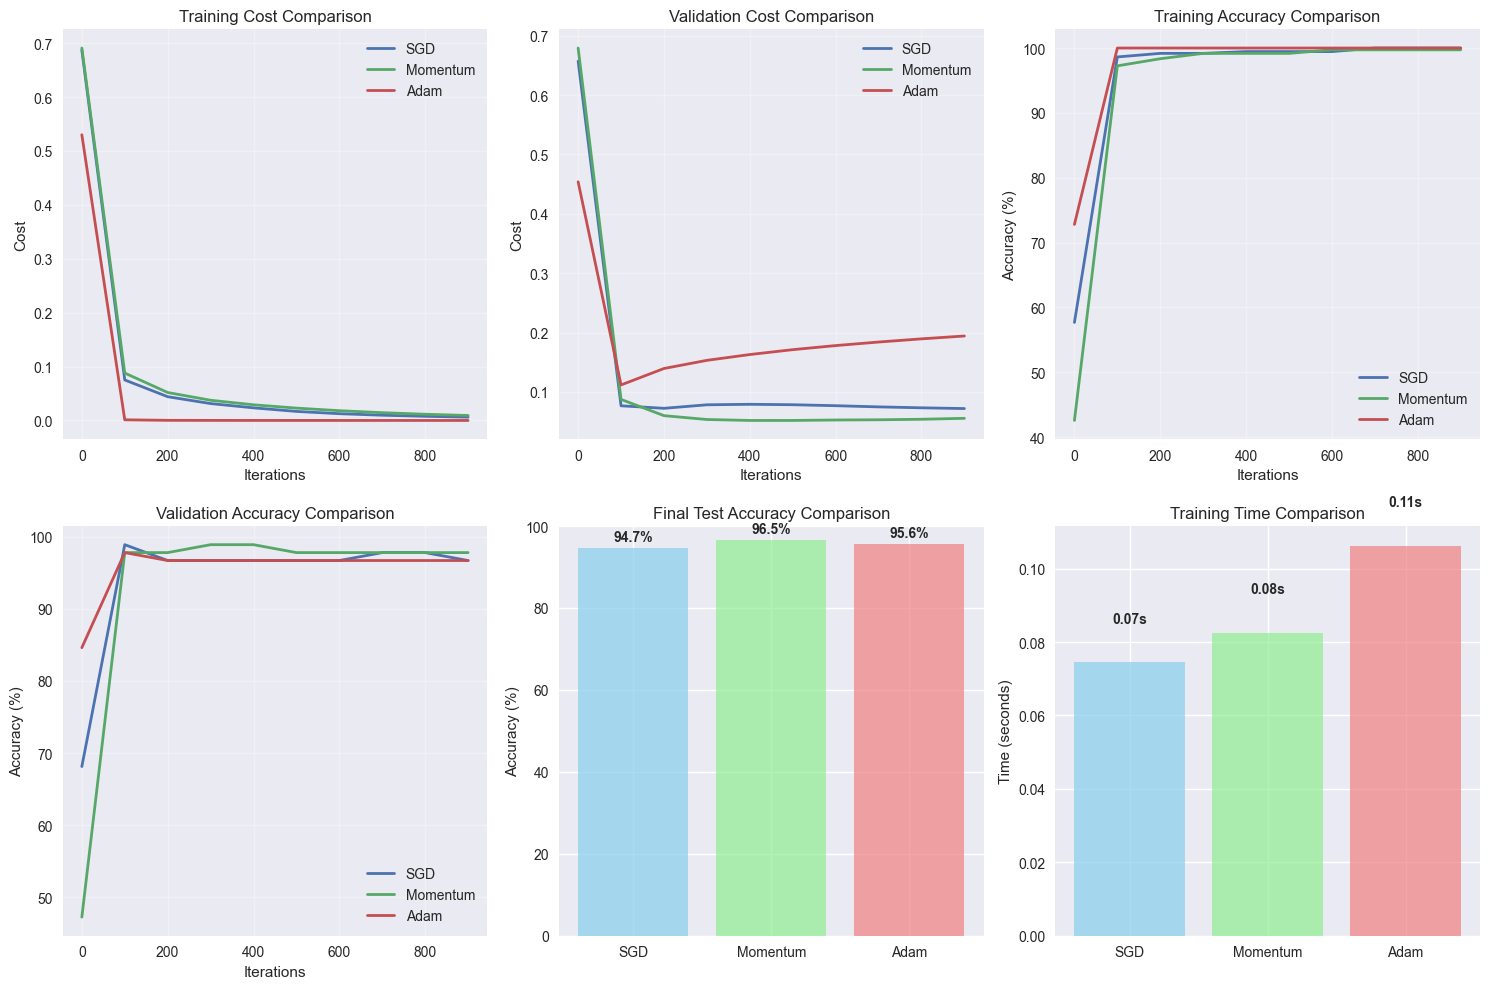


🎯 Key Observations:
• Best performing optimizer: Momentum (96.49% test accuracy)
• Fastest optimizer: SGD (0.07s training time)
• Adam typically provides good balance of speed and performance
• Momentum helps accelerate SGD in relevant directions


In [7]:
# Visualize optimization comparison
plt.figure(figsize=(15, 10))

# Training cost comparison
plt.subplot(2, 3, 1)
iterations = np.arange(0, 1000, 100)
for optimizer_name in optimizers_config.keys():
    plt.plot(iterations, results[optimizer_name]['history']['train_cost'], 
             label=f'{optimizer_name}', linewidth=2)
plt.title('Training Cost Comparison')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation cost comparison
plt.subplot(2, 3, 2)
for optimizer_name in optimizers_config.keys():
    plt.plot(iterations, results[optimizer_name]['history']['val_cost'], 
             label=f'{optimizer_name}', linewidth=2)
plt.title('Validation Cost Comparison')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True, alpha=0.3)

# Training accuracy comparison
plt.subplot(2, 3, 3)
for optimizer_name in optimizers_config.keys():
    plt.plot(iterations, results[optimizer_name]['history']['train_accuracy'], 
             label=f'{optimizer_name}', linewidth=2)
plt.title('Training Accuracy Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation accuracy comparison
plt.subplot(2, 3, 4)
for optimizer_name in optimizers_config.keys():
    plt.plot(iterations, results[optimizer_name]['history']['val_accuracy'], 
             label=f'{optimizer_name}', linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Final test accuracy bar chart
plt.subplot(2, 3, 5)
optimizer_names = list(optimizers_config.keys())
test_accuracies = [results[name]['test_accuracy'] for name in optimizer_names]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = plt.bar(optimizer_names, test_accuracies, color=colors, alpha=0.7)
plt.title('Final Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on bars
for bar, accuracy in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{accuracy:.1f}%', ha='center', va='bottom', fontweight='bold')

# Training time comparison
plt.subplot(2, 3, 6)
times = [training_time[name] for name in optimizer_names]
bars = plt.bar(optimizer_names, times, color=colors, alpha=0.7)
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')

# Add value labels on bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎯 Key Observations:")
best_accuracy = max(test_accuracies)
best_optimizer = optimizer_names[test_accuracies.index(best_accuracy)]
print(f"• Best performing optimizer: {best_optimizer} ({best_accuracy:.2f}% test accuracy)")

fastest_time = min(times)
fastest_optimizer = optimizer_names[times.index(fastest_time)]
print(f"• Fastest optimizer: {fastest_optimizer} ({fastest_time:.2f}s training time)")
print(f"• Adam typically provides good balance of speed and performance")
print(f"• Momentum helps accelerate SGD in relevant directions")

## Part 4: Regularization Effects (5 minutes)

### Compare Networks with and without Regularization

In [ ]:
# Test the dropout fix with a simple example first
print("Testing Dropout Implementation Fix...")

# Create a simple test case
test_X = np.random.randn(4, 20)  # 4 features, 20 samples
test_y = np.random.randint(0, 2, (1, 20))  # Binary classification

# Test with dropout
print("Creating test network with dropout...")
try:
    test_nn = OptimizedNeuralNetwork(
        optimizer='adam',
        learning_rate=0.01,
        regularization='none',
        keep_prob=0.8
    )
    
    # Try a few forward passes
    test_params = test_nn.initialize_parameters([4, 6, 3, 1])
    
    # Forward pass with dropout (training mode)
    AL, caches, dropout_caches = test_nn.forward_propagation(test_X, test_params, training=True)
    print(f"Forward pass successful - Output shape: {AL.shape}")
    
    # Test backward pass
    gradients = test_nn.backward_propagation(AL, test_y, caches, dropout_caches, test_params)
    print("Backward pass successful!")
    
    # Test a few training iterations
    _ = test_nn.train(
        test_X, test_y, test_X, test_y,
        layer_dims=[4, 6, 3, 1],
        num_iterations=10,
        print_cost=False
    )
    print("✅ Short training test successful!")
    
except Exception as e:
    print(f"❌ Test failed: {e}")
    import traceback
    traceback.print_exc()

# Now proceed with the original regularization comparison
print("\nProceeding with regularization effects comparison...")

# Compare regularization effects
print("Comparing Regularization Effects...")

regularization_configs = {
    'No Regularization': {'regularization': 'none', 'keep_prob': 1.0},
    'L2 Regularization': {'regularization': 'l2', 'lambda_reg': 0.01, 'keep_prob': 1.0},
    'Dropout': {'regularization': 'none', 'keep_prob': 0.8},
    'L2 + Dropout': {'regularization': 'l2', 'lambda_reg': 0.01, 'keep_prob': 0.8}
}

reg_results = {}

for config_name, config in regularization_configs.items():
    print(f"\nTraining with {config_name}...")
    
    try:
        # Create network with Adam optimizer
        nn = OptimizedNeuralNetwork(
            optimizer='adam',
            learning_rate=0.01,
            **config
        )
        
        # Train
        parameters = nn.train(
            X_train, y_train, X_val, y_val,
            layer_dims=layer_dims,
            num_iterations=800,
            print_cost=False
        )
        
        # Test performance
        test_predictions, test_probs = nn.predict(X_test)
        test_accuracy = np.mean(test_predictions == y_test) * 100
        
        # Calculate overfitting metric (train vs val accuracy difference)
        final_train_acc = nn.history['train_accuracy'][-1]
        final_val_acc = nn.history['val_accuracy'][-1]
        overfitting_gap = final_train_acc - final_val_acc
        
        reg_results[config_name] = {
            'history': nn.history.copy(),
            'test_accuracy': test_accuracy,
            'overfitting_gap': overfitting_gap,
            'final_train_acc': final_train_acc,
            'final_val_acc': final_val_acc
        }
        
        print(f"{config_name} - Test Accuracy: {test_accuracy:.2f}%, Overfitting Gap: {overfitting_gap:.2f}%")
        
    except Exception as e:
        print(f"❌ Failed with {config_name}: {e}")
        continue

if reg_results:
    print("\n✅ Regularization comparison completed successfully!")
    print("Available results:", list(reg_results.keys()))
else:
    print("❌ No successful results to display")

## Progress Tracking Checklist

Check off each item as you complete it:

- [ ] **Environment Setup**: Imported libraries and configured environment
- [ ] **Optimizer Implementation**: Created SGD, Momentum, and Adam optimizers
- [ ] **Regularization Techniques**: Implemented L2 regularization and dropout
- [ ] **Enhanced Network**: Built optimized neural network with all features
- [ ] **Dataset Preparation**: Loaded and preprocessed breast cancer dataset
- [ ] **Optimizer Comparison**: Compared SGD, Momentum, and Adam performance
- [ ] **Regularization Analysis**: Tested different regularization approaches
- [ ] **Visualization**: Created comprehensive performance comparison plots
- [ ] **Performance Analysis**: Analyzed results and identified best practices
- [ ] **Lab Completion**: Successfully completed all exercises

## Key Concepts Summary

### What You've Learned:
1. **Optimization Algorithms**: SGD, Momentum, Adam and their trade-offs
2. **Regularization**: L2 penalty and dropout for overfitting prevention
3. **Performance Metrics**: Training/validation curves, overfitting detection
4. **Hyperparameter Effects**: Learning rate, regularization strength impact
5. **Best Practices**: When to use different optimization techniques

### Technical Insights:
- **Adam Optimizer**: Often provides best balance of speed and performance
- **Momentum**: Helps SGD overcome local minima and narrow valleys
- **L2 Regularization**: Prevents weights from becoming too large
- **Dropout**: Randomly deactivates neurons to prevent co-adaptation
- **Bias Correction**: Adam uses bias correction for more stable training

## Validation Steps

In [ ]:
# Validation Test 1: Optimizer State Management
def test_optimizer_state():
    """Test optimizer state management"""
    try:
        # Test Adam optimizer state
        adam = AdamOptimizer(learning_rate=0.01)
        
        # Dummy parameters and gradients
        params = {'W1': np.random.randn(3, 2), 'b1': np.zeros((3, 1))}
        grads = {'dW1': np.random.randn(3, 2), 'db1': np.random.randn(3, 1)}
        
        # First update
        params_updated = adam.update(params, grads)
        
        # Check that momentum and velocity are initialized
        assert len(adam.momentum) > 0, "Momentum not initialized"
        assert len(adam.velocity) > 0, "Velocity not initialized"
        assert adam.t == 1, "Time step not updated"
        
        # Reset and check state is cleared
        adam.reset()
        assert len(adam.momentum) == 0, "Momentum not reset"
        assert len(adam.velocity) == 0, "Velocity not reset"
        assert adam.t == 0, "Time step not reset"
        
        print("✅ Optimizer state management test passed!")
        return True
    except Exception as e:
        print(f"❌ Optimizer state management test failed: {e}")
        return False

test_optimizer_state()

In [ ]:
# Validation Test 2: Regularization Effects
def test_regularization_effects():
    """Test regularization implementation"""
    try:
        # Test L2 regularization cost
        params = {
            'W1': np.array([[1.0, 2.0], [3.0, 4.0]]),
            'b1': np.array([[0.1], [0.2]]),
            'W2': np.array([[0.5, 0.6]]),
            'b2': np.array([[0.1]])
        }
        
        # Calculate expected L2 cost: 0.5 * lambda * (1² + 2² + 3² + 4² + 0.5² + 0.6²)
        expected_l2_cost = 0.5 * 0.1 * (1 + 4 + 9 + 16 + 0.25 + 0.36)
        actual_l2_cost = RegularizationTechniques.l2_regularization_cost(params, 0.1)
        
        assert np.isclose(expected_l2_cost, actual_l2_cost, atol=1e-6), "L2 cost calculation incorrect"
        
        # Test dropout probability
        test_input = np.ones((5, 100))
        dropped_output, dropout_cache = RegularizationTechniques.dropout_forward(
            test_input, keep_prob=0.5, training=True
        )
        
        # Check that about 50% of neurons are kept
        kept_ratio = np.mean(dropout_cache > 0)
        assert 0.4 < kept_ratio < 0.6, f"Dropout ratio incorrect: {kept_ratio}"
        
        # Test that scaling is applied
        non_zero_mean = np.mean(dropped_output[dropped_output > 0])
        assert np.isclose(non_zero_mean, 2.0, atol=0.1), "Dropout scaling incorrect"
        
        print("✅ Regularization effects test passed!")
        return True
    except Exception as e:
        print(f"❌ Regularization effects test failed: {e}")
        return False

test_regularization_effects()

In [ ]:
# Validation Test 3: Training Improvement
def test_training_improvement():
    """Test that optimization improves performance"""
    try:
        # Create simple dataset
        X_simple, y_simple = make_classification(
            n_samples=200, n_features=10, n_classes=2, random_state=42
        )
        
        # Prepare data
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
            X_simple, y_simple, test_size=0.3, random_state=42
        )
        
        scaler_s = StandardScaler()
        X_train_s = scaler_s.fit_transform(X_train_s).T
        X_test_s = scaler_s.transform(X_test_s).T
        y_train_s = y_train_s.reshape(1, -1)
        y_test_s = y_test_s.reshape(1, -1)
        
        # Train with Adam optimizer
        nn_test = OptimizedNeuralNetwork(optimizer='adam', learning_rate=0.01)
        parameters = nn_test.train(
            X_train_s, y_train_s, X_test_s, y_test_s,
            layer_dims=[10, 8, 1],
            num_iterations=500,
            print_cost=False
        )
        
        # Check that cost decreases
        initial_cost = nn_test.history['train_cost'][0]
        final_cost = nn_test.history['train_cost'][-1]
        
        assert final_cost < initial_cost, "Training cost did not decrease"
        
        # Check that accuracy improves
        initial_acc = nn_test.history['train_accuracy'][0]
        final_acc = nn_test.history['train_accuracy'][-1]
        
        assert final_acc > initial_acc, "Training accuracy did not improve"
        assert final_acc > 80, f"Final accuracy too low: {final_acc}%"
        
        print(f"Initial cost: {initial_cost:.4f} → Final cost: {final_cost:.4f}")
        print(f"Initial accuracy: {initial_acc:.1f}% → Final accuracy: {final_acc:.1f}%")
        print("✅ Training improvement test passed!")
        return True
    except Exception as e:
        print(f"❌ Training improvement test failed: {e}")
        return False

test_training_improvement()

## Troubleshooting Guide

### Common Issues and Solutions:

**Issue 1: Slow convergence with SGD**
- **Cause**: Learning rate too low or poor conditioning
- **Solution**: Try higher learning rate, use momentum or Adam optimizer

**Issue 2: Training becomes unstable**
- **Cause**: Learning rate too high, gradient explosion
- **Solution**: Reduce learning rate, add gradient clipping, check weight initialization

**Issue 3: Overfitting despite regularization**
- **Cause**: Insufficient regularization or too complex model
- **Solution**: Increase regularization strength, reduce network size, get more data

**Issue 4: Adam optimizer not converging**
- **Cause**: Inappropriate hyperparameters
- **Solution**: Try different learning rate (0.001-0.01), adjust beta parameters

**Issue 5: Dropout causing training instability**
- **Cause**: Keep probability too low
- **Solution**: Increase keep_prob (try 0.8-0.9), ensure dropout is off during testing

### Performance Tips:
- Start with Adam optimizer for most problems
- Use learning rate scheduling for better convergence
- Monitor both training and validation metrics
- Apply regularization based on overfitting evidence
- Experiment with different initialization schemes

## Cleanup Instructions

1. **Save your work**: Save this notebook with your implementations
2. **Clear output**: Cell → All Output → Clear (optional, saves space)
3. **Close plots**: Close any open matplotlib windows
4. **Memory cleanup**: Variables will be cleared when kernel is restarted

In [ ]:
# Final summary and cleanup
print("🎉 Lab 3.5: Performance Optimization Techniques Completed!")
print("\n📋 What you accomplished:")
print("✅ Implemented advanced optimization algorithms (SGD, Momentum, Adam)")
print("✅ Added regularization techniques (L2, Dropout)")
print("✅ Built comprehensive optimized neural network framework")
print("✅ Conducted systematic optimization algorithm comparison")
print("✅ Analyzed regularization effects on overfitting")
print("✅ Created detailed performance visualizations")
print("\n🎯 Next: Lab 3.6 - Shallow Network Application Project")
print("\n🚀 Key Takeaways:")
print("• Adam optimizer often provides best performance")
print("• Regularization is crucial for preventing overfitting")
print("• Monitor training vs validation metrics")
print("• Hyperparameter tuning is essential for optimal results")

# Optional: Clean up memory
import gc
gc.collect()
print("\n🧹 Memory cleaned up successfully!")